# Project initialization

## Importing libraries

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import warnings
warnings.filterwarnings("ignore")

This project uses a dataset created by reddit user "JLD_" in 2018. The dataset contains the Coffee Quality Institute's (CQI from now on) bean reviews going back multiple years. The author of the dataset already did some cleaning on the data, however for the purposes of this project it needed some additional cleaning/fixing up.

Link: https://www.reddit.com/r/datasets/comments/8rndor/data_on_1340_coffee_bean_reviews_aroma_acidity/

The dataset mostly needed minor corrections as seen below. The columns names were standardized, unit of measurement was also standardized, and some of the altitude data needed correcting. Harvest Year information was all over the place in different formats, so I decided only to keep the year data as the rest was not needed for my research. For missing information the Grading Date was used as a substitute. Country names needed minor correction as well, mostly to fix typos. In the end I dropped all rows that did not have a Total Cup Point value as this was the value I used for rating calculations and graphs.

## Importing and cleaning the dataset

In [339]:
# coffee beans in a certain coffe store
df = pd.read_csv("data/coffeebeans.csv", parse_dates=["Harvest.Year"])

# change column names '.' to '_'
df.columns = df.columns.str.replace('.', '_')

# change feet to meter (all altitudes are already converted to meter, the unit was not corrected)
df["unit_of_measurement"] = 'm'

# fix wrong altitude values
df.iloc[543, 41:44] = 1100.0
df.iloc[896, 41:44] = 1901.64
df.iloc[1144, 41:44] = 1901.64
df.iloc[1040, 41:44] = 1100.0

# convert harvest year to dates (some dates are in weird format, these will be lost during conversion)
df["Harvest_Year"] = pd.to_datetime(df["Harvest_Year"], errors="coerce")

# use grading dates for missing harvest years as these are pretty close to the harvest year
df["Harvest_Year"].fillna(df["Grading_Date"], inplace=True)

# only keep Year from the timestamp
df["Harvest_Year"] = df["Harvest_Year"].dt.strftime("%Y")

# replace country names
countries = ["Tanzania, United Republic Of", "United States (Hawaii)", "United States (Puerto Rico)", "Cote d?Ivoire"]
countries_new = ["Tanzania", "Hawaii", "Puerto Rico", "Cote d'Ivoire"]

for c, cn in zip(countries, countries_new):
    df = df.replace(to_replace=c, value=cn)
    
# drop values with missing tcp rating
df = df[df["Total_Cup_Points"] > 0]

## Number of coffee bean types per country

This is a simple pie chart that shows the number of coffee bean types reviewed by the CQI per country.

We can clearly see that most of the coffee beans originate from the countries of Mexico, Guatemala and Colombia, with Brazil also producing a large chunk of unique coffee beans. These 4 countries make up more than half of all coffee beans produced and reviewed by CQI.

Some countries were also left out from the pie chart as they only produced 1 unique coffee bean type.

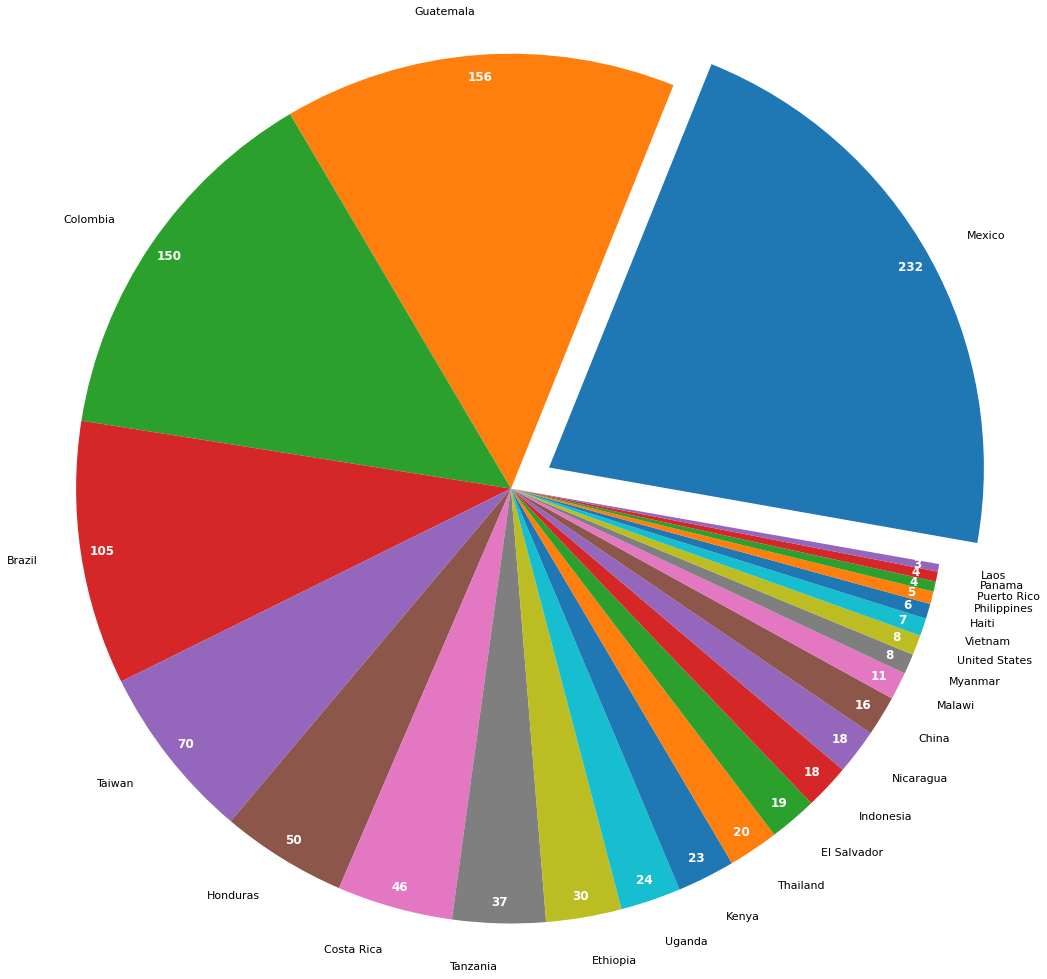

In [216]:
coffee_per_country = df.groupby(["Country_of_Origin"]).count()

# only show countries that have more than one coffee bean type
coffee_per_country = coffee_per_country[~(coffee_per_country["Species"] <= 2)]
coffee_per_country_sorted = coffee_per_country.sort_values(by="Species", ascending=False)

# sum of all coffee types for pie chart label values
sum_coffee_countries = coffee_per_country_sorted["Species"].sum()
sum_coffee_countries

# pie chart setup
fig, ax = plt.subplots(figsize=(10,10))

# create list to explode highest value, keep rest intact
explode_list = [0.2]

i = 0
while i < len(coffee_per_country_sorted.index)-1:
    explode_list.append(0)
    i+=1

# create pie
wedge, text, autopct = ax.pie(coffee_per_country_sorted["Species"], radius=2, labels=coffee_per_country_sorted.index, startangle=-10, explode=explode_list, autopct=lambda x: "{:.0f}".format(x * sum_coffee_countries / 100), pctdistance=0.95)

# format text values
plt.setp(autopct, **{'color':'white', 'weight':'bold', 'fontsize':12})
plt.setp(text, **{'color':'black', 'fontsize':11})

plt.show()

## Number of coffee bean types per harvest year

The next chart is a line graph that shows us the number of coffee bean types produced each year. 

Since the data was scraped in 2018, the data might be incomplete for that year as that is the lowest value on the graph. 

The second lowest value is 2010, while the highest number of coffee bean types harvested in a single year was in 2012.

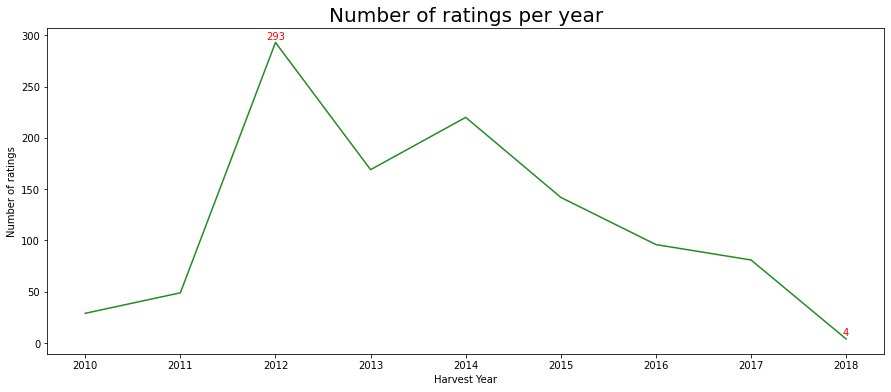

In [203]:
ctype_per_year = df.groupby(["Harvest_Year"])["Species"].count()

# line plot setup
fig,ax = plt.subplots(figsize=(15,6))

ax.plot(ctype_per_year.index, ctype_per_year.values, color="forestgreen")

# set labels/title
ax.set_xlabel("Harvest Year")
ax.set_ylabel("Number of ratings")
ax.set_title(("Number of ratings per year"), fontsize=20)

# show min and max
ax.text(ctype_per_year.idxmax(), ctype_per_year.max()+6, round(ctype_per_year.max(), 2), fontsize=10, va="center", ha="center",  color="red")
ax.text(ctype_per_year.idxmin(), ctype_per_year.min()+6, round(ctype_per_year.min(), 2), fontsize=10, va="center", ha="center",  color="red")

plt.show()

## Average rating of coffee beans by year

For our next line graph we are evaluating the values of the rating given by the CQI in each year. 

What's interesting is that the average of the rating for a given year is the lowest in 2012 which is also the same year that had the most coffee bean types rated. 

The highest value however, is for 2010 which in our previous graph was the second smallest number (right after 2018 which as we know is when the data was collected). 

Looking at the graph it also looks almost like an inverse of the previous number of rating graph. This leads me to think there might be a correlation between the average of ratings and the number of ratings, where the more coffee bean types are reviewed leads to a lower average score. Of course, that would need to be analysed with more in-depth analysis tools (and probably with a more complete dataset).

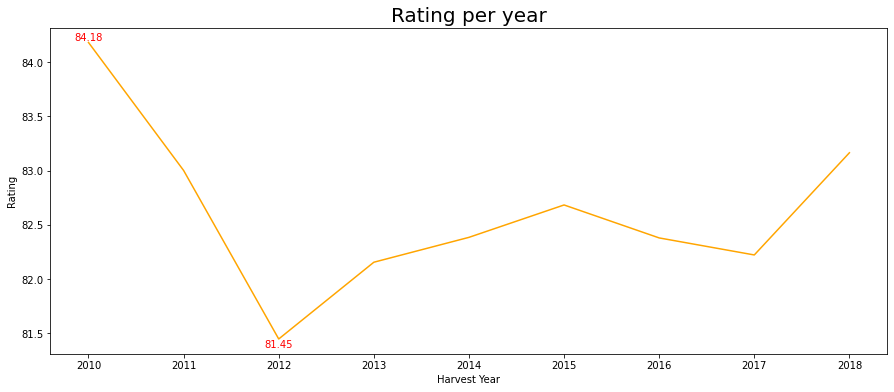

In [217]:
rating_per_year = df.groupby(["Harvest_Year"]).mean()

# line plot setup
fig,ax = plt.subplots(figsize=(15,6))

ax.plot(rating_per_year.index, rating_per_year["Total_Cup_Points"], color="orange")

# set labels/title
ax.set_xlabel("Harvest Year")
ax.set_ylabel("Rating")
ax.set_title(("Rating per year"), fontsize=20)

# show min and max
ax.text(rating_per_year["Total_Cup_Points"].idxmax(), rating_per_year["Total_Cup_Points"].max()+0.05, round(rating_per_year["Total_Cup_Points"].max(), 2), fontsize=10, va="center", ha="center",  color="red")
ax.text(rating_per_year["Total_Cup_Points"].idxmin(), rating_per_year["Total_Cup_Points"].min()-0.05, round(rating_per_year["Total_Cup_Points"].min(), 2), fontsize=10, va="center", ha="center",  color="red")

plt.show()

## Average rating of coffee beans by year on interpolated spline chart

An interpolated chart of the rating averages that shows us a slightly more natural progress of ratings along time.

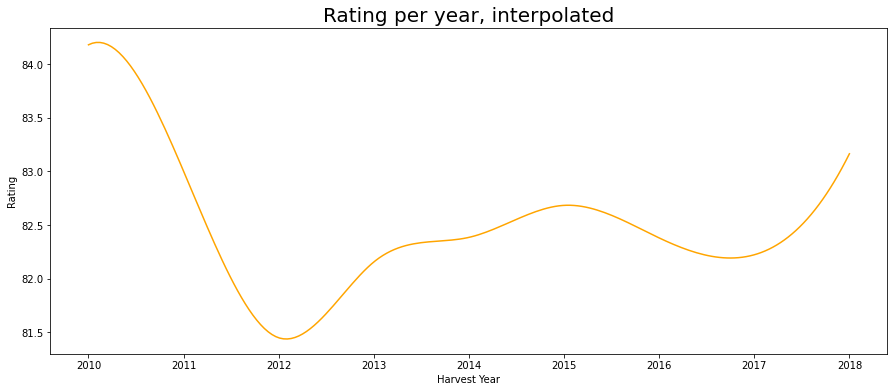

In [208]:
rating_per_year = df.groupby(["Harvest_Year"]).mean()

x = np.array(rating_per_year.index)
y = np.array(rating_per_year["Total_Cup_Points"])

#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(float(x.min()), float(x.max()), 200) 

#define spline
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(xnew)

# line plot setup
fig,ax = plt.subplots(figsize=(15,6))

ax.plot(xnew, y_smooth, color="orange")

# set labels/title
ax.set_xlabel("Harvest Year")
ax.set_ylabel("Rating")
ax.set_title(("Rating per year, interpolated"), fontsize=20)

plt.show()

## Average rating of coffee beans by year per country

While our previous charts' contained all countries averaged rating, in this next one we're looking to see the countries that had received a rating in most years. The criterium is that only 1 year of missing rating is accepted. 

No really big surprises there on which countries made the cut, as the 4 largest coffee producers (Mexico, Colombia, Guatemala and Brazil) each got ratings in almost all years. 

It is interesting though, that Taiwan, Honduras, Costa Rica and Tanzania while producing plenty of coffee beans, can not be seen on the graph as they had at least 2 years of missing ratings. Might be a good idea to cross reference the missing years of these coffee producing countries with other datasets containing weather information. Or there could be other external issues at hand, like exporting issues or such (or just the CQI not having the capacity to rate so many coffee beans?).

Fewer unique coffee beans come from Ethiopia and Indonesia so only take a much smaller chunk on the pie chart, yet they consistently produced coffees rated by the CQI for most years.

We can also see that although Mexico produces the most unique coffee bean types for any country, they are also not nearly as highly rated as Ethiopian coffee beans. This graph could also be skewed by what I mentioned before about the probable correlation between the number of coffee bean types and ratings and the average ratings.

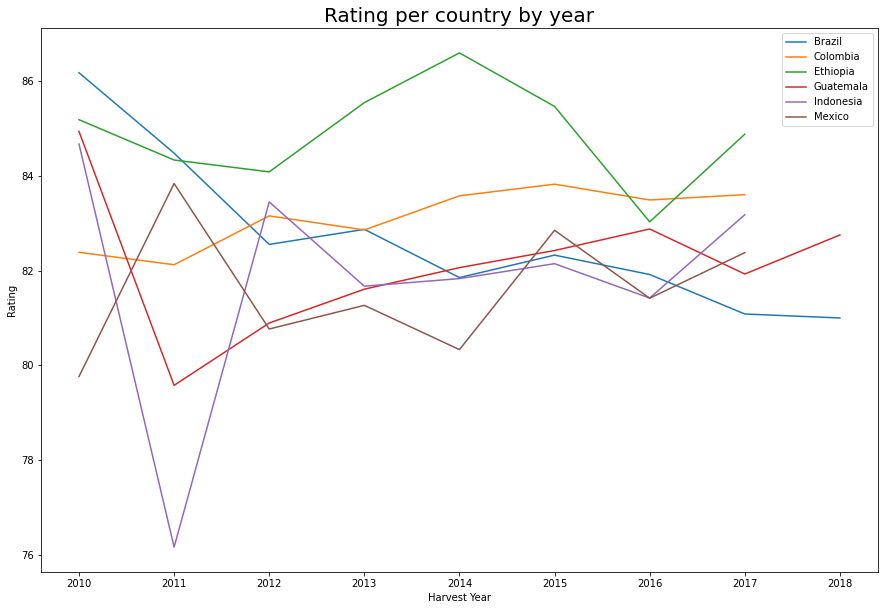

In [8]:
rating_per_year_country = df.groupby(["Harvest_Year", "Country_of_Origin"])["Total_Cup_Points"].mean().unstack()

# only create plot for countries with at least 8 ratings
rating_per_year_country = rating_per_year_country.loc[:,rating_per_year_country.notna().sum(0) >= 8]

# line plot setup
fig,ax = plt.subplots(figsize=(15,10))

ax.plot(rating_per_year_country.index, rating_per_year_country.values)

# set labels/title
ax.set_xlabel("Harvest Year")
ax.set_ylabel("Rating")
ax.set_title(("Rating per country by year"), fontsize=20)
ax.legend(rating_per_year_country.columns,loc="best")

plt.show()

## Average rating of coffee beans per country

Now on a bar graph we can see all countries that have had at least 10 rated coffee beans produced. The brown spotted line represents the average rating of every single coffee bean in the dataset.

Ethiopia, once again at the top of the pack, well above the average. Kenya and Uganda, that produced a similar amount of coffee bean types in the same time following close behind.

Still, we can see that even large coffee bean producing countries can get good ratings: Colombia is the fourth on the graph.

This time though, Mexico, Guatemala and Brazil fall behind. While Brazil's average rating hits the total average rating, Guatemalan and Mexican coffee in general is below average quality according to CQI. 

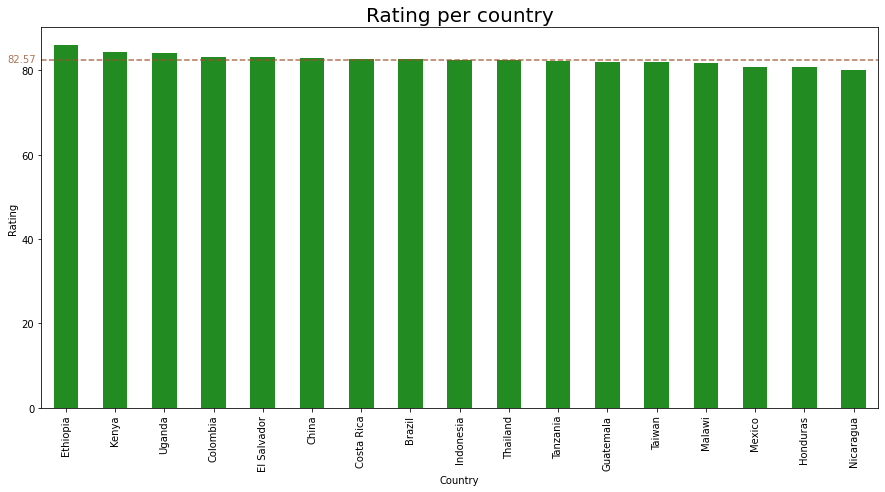

In [388]:
rating_per_country = df.groupby("Country_of_Origin").agg(count=("Country_of_Origin", "size"), mean=("Total_Cup_Points", "mean")).reset_index()
rating_per_country = rating_per_country[rating_per_country["count"] >= 10]
rating_per_country = rating_per_country.sort_values(by="mean", ascending=False)
rating_per_country.set_index(rating_per_country["Country_of_Origin"], inplace=True)
rating_per_country.drop(columns=['count'], inplace=True)

# bar plot setup
fig,ax = plt.subplots()
c = ["forestgreen", "sienna"]
rating_per_country.plot(kind="bar", ax=ax, color=c, figsize=(15,7))

# set labels/title
ax.set_xlabel("Country")
ax.set_ylabel("Rating")
ax.set_title(("Rating per country"), fontsize=20)

# add horizontal line for average
mean = rating_per_country["mean"].mean()
ax.axhline(mean, alpha=0.8, linestyle="--", color="sienna")
ax.text(-0.9, mean, round(mean, 2), fontsize=10, va="center", ha="center",  color="sienna", alpha=0.8)

# remove legend
legend = ax.legend().remove()

plt.show()

## Average rating of coffee beans per country with number of ratings

This bar chart is just an extension of the previous one. It contains both the ratings and the number of ratings on the same graph for each country.

The green spotted line is the average number of ratings a country gets.

The graph still does not paint a full picture of the correlation between number of ratings and the average ratings but we can see that the countries on the right end of the graph got a lower rating and mostly have higher number of ratings than the ones on the left side (excluding Malawi as it received a similar amount of ratings as the countries on the left).

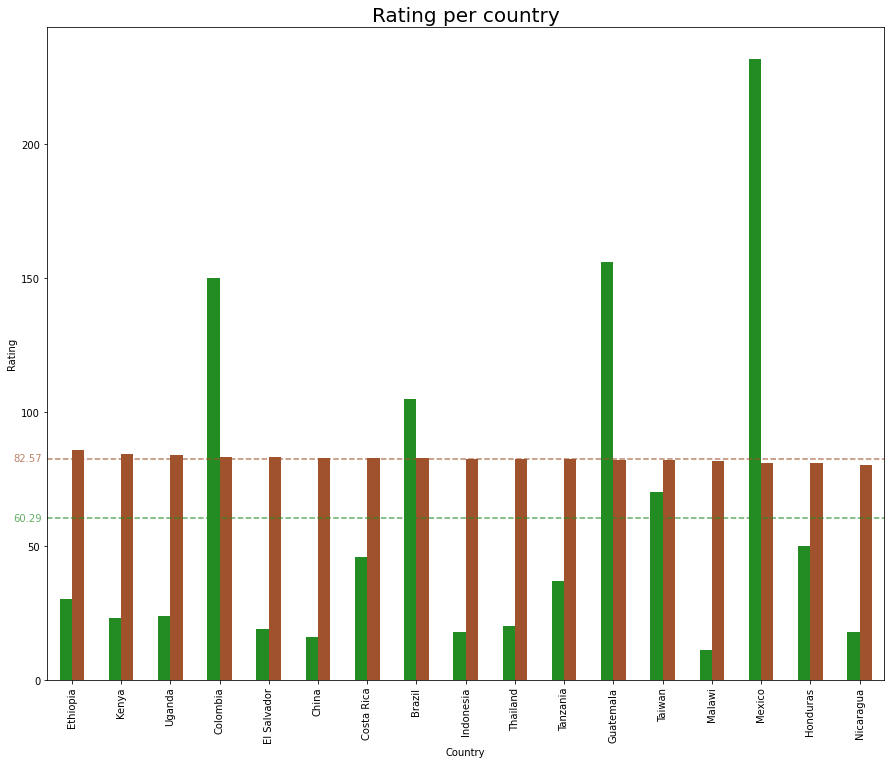

In [226]:
rating_per_country = df.groupby("Country_of_Origin").agg(count=("Country_of_Origin", "size"), mean=("Total_Cup_Points", "mean")).reset_index()
rating_per_country = rating_per_country[rating_per_country["count"] >= 10]
rating_per_country = rating_per_country.sort_values(by="mean", ascending=False)
rating_per_country.set_index(rating_per_country["Country_of_Origin"], inplace=True)

# bar plot setup
fig,ax = plt.subplots()
c = ["forestgreen", "sienna"]
rating_per_country.plot(kind="bar", ax=ax, color=c, figsize=(15,12))

# set labels/title
ax.set_xlabel("Country")
ax.set_ylabel("Rating")
ax.set_title(("Rating per country"), fontsize=20)

# add horizontal line for average
mean = rating_per_country["mean"].mean()
c_mean =  rating_per_country["count"].mean()
ax.axhline(mean, alpha=0.7, linestyle="--", color="sienna")
ax.text(-0.9, mean, round(mean, 2), fontsize=10, va="center", ha="center",  color="sienna", alpha=0.7)
ax.axhline(c_mean, alpha=0.7, linestyle="--", color="forestgreen")
ax.text(-0.9, c_mean, round(c_mean, 2), fontsize=10, va="center", ha="center",  color="forestgreen", alpha=0.7)

# remove legend
legend = ax.legend().remove()

plt.show()

## Coffee bean producing region elevations per country

To further our analysis of each countries' coffee ratings, we should also take into account the elevation levels of coffee bean farms. Different elevations can change the aroma and flavor of the coffee beans and certain coffee beans can only be produced at certain elevations.

The graph shows us that the average elevation where coffee beans are produced is 1281m. It is obvious while reading the chart that most countries' average elevation of coffee bean producing farms are really close to the average line. 

There are some notable exceptions of course, like Myanmar, where the average altitude for producing coffee is more than double the average with 2870 meter.

Some countries, such as Japan, Cote d'Ivoire and Mauritius have a much lower average for altitudes in the range of 150-300 meters and no lower and higher points. If we go back to the pie chart we can't see any of these countries there, which means that this only comes from a single coffee bean's data. Thus I would say this data is not necessarily representative.

What is important on this graph though, is that we can see the large difference between the lowest and highest elevations of each countries' coffee producing regions along with their average elevation for the farms. 

For the largest coffee producing regions: 
* Mexico, which has the highest number of coffee beans and lowest average ratings, we should notice that there are coffee bean producing regions well under the average elevation. Mexico's average altitude for coffee farms is slightly below the overall average.
* Guatemala, with the second highest number of coffee bean types produced, has a much higher elevation difference between its lowest and highest farms. Guatemalan coffe is only rated slightly higher than Mexican, while also having its average altitude slightly higher too (and slightly higher than the overall average as). 
* Colombia, the third by the number of coffee beans produced, however had a somewhat higher than average rating, being the 4th of all countries, is leading the chart with the difference between the lowest and highest altitude. Its average elevation is 300 meters above the overall average.
* Brazil, similarly to Mexico, does not have farms at much higher elevation than the average and its own average is 300 meters below the overall countries average.
* Ethiopia, as the highest rated coffee bean producer, with a moderate amount of coffee bean types has a medium range between the lowest and highest points but its average altitude is a whopping 500 meters above the overall average.


To me this looks like the average rating of a country's coffee beans is probably higher if that country's average altitude for producing coffee is higher.
It should be noted here that another analysis that tells us the number of farms per elevation (for each country) could help us see clearer.

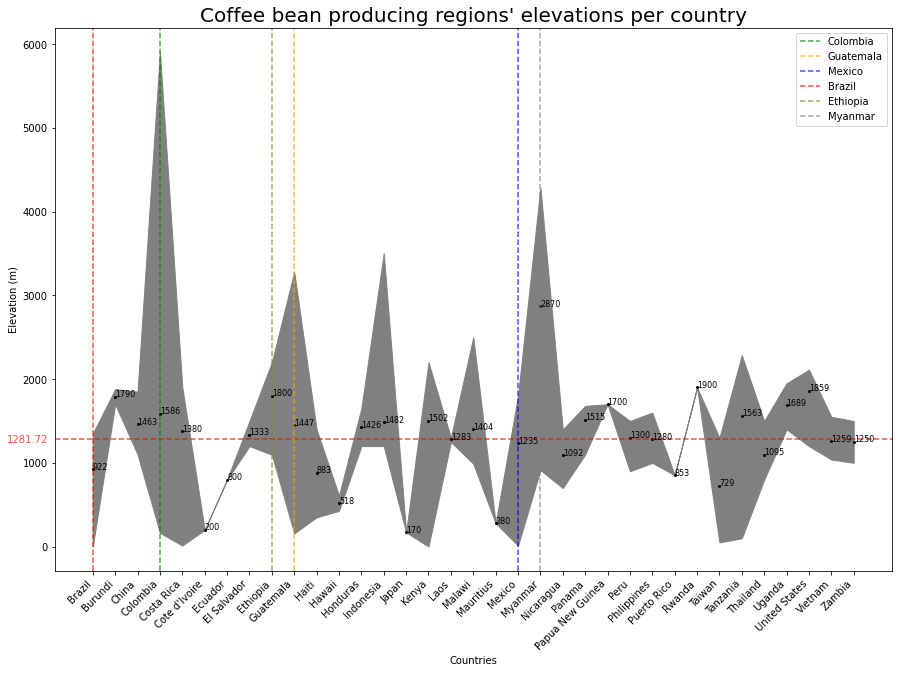

In [346]:
# drop rows that have no altitude data
df = df.dropna(subset=["altitude_mean_meters"])

# get lowest and highest elevation of coffee producing region per country
country_minimum_alt = df.groupby(["Country_of_Origin"])["altitude_low_meters"].min()
country_maximum_alt = df.groupby(["Country_of_Origin"])["altitude_high_meters"].max()

# get the average for each country by averaging their regional averages
country_mean_alt = df.groupby(["Country_of_Origin"])["altitude_mean_meters"].mean()

# average elevation for coffee bean producing
avg_alt = df["altitude_mean_meters"].mean()

# fillbetween, scatter plots setup
fig,ax = plt.subplots(figsize=(15,10))

ax.fill_between(country_minimum_alt.index, country_minimum_alt.values, country_maximum_alt.values, color="gray")
ax.scatter(country_mean_alt.index, country_mean_alt.values, color="black", s=4)

# set labels, title
ax.set_xlabel("Countries")
ax.set_ylabel("Elevation (m)")
ax.set_title(("Coffee bean producing regions' elevations per country"), fontsize=20)
ax.set_xticklabels(country_minimum_alt.index, rotation=45, ha='right')

# add horizontal line for average
mean = country_mean_alt.values.mean()
ax.axhline(mean, alpha=0.7, linestyle="--", color="red")
ax.text(-2.9, mean, round(mean, 2), fontsize=10, va="center", ha="center", backgroundcolor="w", color="red", alpha=0.7)

# add vertical lines for select countries
countries=["Colombia", "Guatemala", "Mexico", "Brazil", "Ethiopia", "Myanmar"]
colors=["green", "orange", "blue", "red", "olivedrab", "gray"]

for cntr, clr in list(zip(countries, colors)):
    ax.axvline(cntr, alpha=0.7, linestyle="--", color=clr, label=cntr)

# show values of each country's average elevation point of farms
for cma_id, cma_val in list(zip(country_mean_alt.index, country_mean_alt.values)):
    ax.annotate(round(cma_val),xy=(cma_id, cma_val+0.1), fontsize=8, color="black")

legend = ax.legend()
    
plt.show()

## Coffee bean producing region occurence for different elevations per country

This graph lists all farms for all countries across different elevations.

Combined with the previous graph now we can see the most common elevation for each country.

Based on this chart it can be seen:
* Mexico's coffee bean farms exist almost equally above and below the average line. 
* Guatemalan regions occure most commonly slightly above the average line.
* Colombian regions are located higher than Guatemalan regions.
* Most of Brazil's coffee producing regions' mean elevations are under the overall average elevation
* Ethiopian farms are almost exclusively found in the range of 1500-2000 meters of elevation.
* Kenya and Uganda has farms at similar elevation levels as Ethiopia, and similar ratings as well.
* Tanzania, weirdly, does not follow this trend as Tanzanian coffee beans received a lower average rating but are produced at a similar altitude.

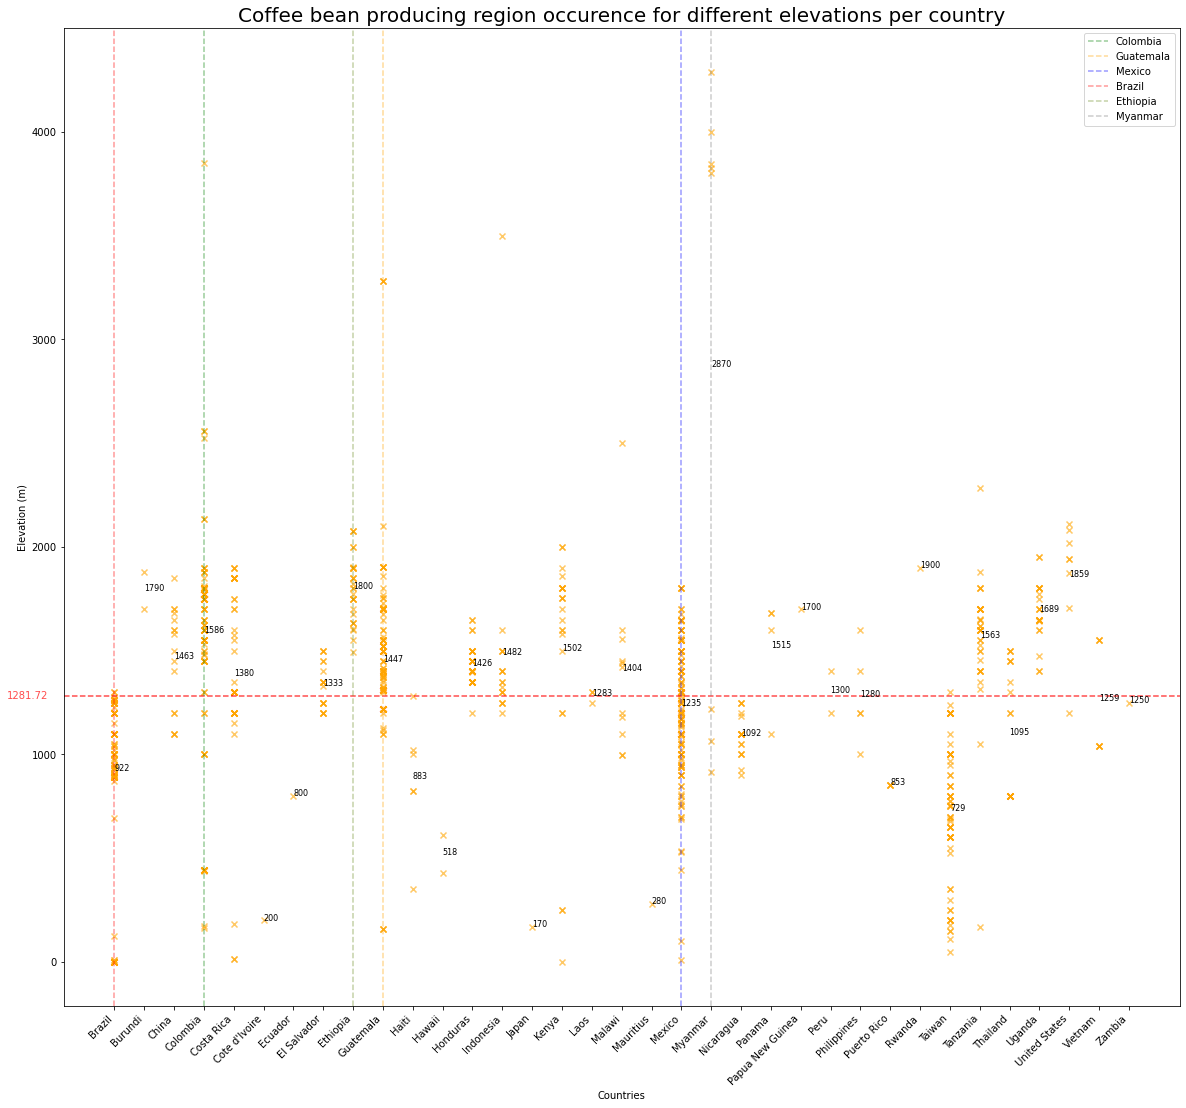

In [385]:
# get all mean altitudes of countries
country_altitudes = df[["Country_of_Origin", "altitude_mean_meters"]].set_index("Country_of_Origin")
country_altitudes.sort_values(by="Country_of_Origin", inplace=True)
country_altitudes_low = df[["Country_of_Origin", "altitude_low_meters"]].set_index("Country_of_Origin")
country_altitudes_low.sort_values(by="Country_of_Origin", inplace=True)
country_altitudes_high = df[["Country_of_Origin", "altitude_high_meters"]].set_index("Country_of_Origin")
country_altitudes_high.sort_values(by="Country_of_Origin", inplace=True)

# get the average for each country by averaging their regional averages
country_mean_alt = df.groupby(["Country_of_Origin"])["altitude_mean_meters"].mean()

# average elevation for coffee bean producing
avg_alt = df["altitude_mean_meters"].mean()

# fillbetween, scatter plots setup
fig,ax = plt.subplots(figsize=(20,18))

ax.scatter(country_altitudes.index, country_altitudes["altitude_mean_meters"], color="orange",  marker="x", alpha=0.6)
#ax.scatter(country_altitudes_low.index, country_altitudes_low["altitude_low_meters"], color="plum",  marker="1", alpha=1)
#ax.scatter(country_altitudes_high.index, country_altitudes_high["altitude_high_meters"], color="mediumaquamarine",  marker="2", alpha=1)

# set labels, title
ax.set_xlabel("Countries")
ax.set_ylabel("Elevation (m)")
ax.set_title(("Coffee bean producing region occurence for different elevations per country"), fontsize=20)
ax.set_xticklabels(country_mean_alt.index, rotation=45, ha='right')

# add horizontal line for average
mean = country_mean_alt.values.mean()
ax.axhline(mean, alpha=0.7, linestyle="--", color="red")
ax.text(-2.9, mean, round(mean, 2), fontsize=10, va="center", ha="center", backgroundcolor="w", color="red", alpha=0.7)

# vertical lines for select countries
countries=["Colombia", "Guatemala", "Mexico", "Brazil", "Ethiopia", "Myanmar"]
colors=["green", "orange", "blue", "red", "olivedrab", "gray"]

for cntr, clr in list(zip(countries, colors)):
    ax.axvline(cntr, alpha=0.4, linestyle="--", color=clr, label=cntr)

# show values of each country's average elevation point of farms
for cma_id, cma_val in list(zip(country_mean_alt.index, country_mean_alt.values)):
    ax.annotate(round(cma_val),xy=(cma_id, cma_val+0.1), fontsize=8, color="black")

legend = ax.legend()
    
plt.show()

## Average rating of coffee beans per elevation

While in the previous graph I had the notion that there could be a correlation between altitude and rating, I wanted to see if it it is a linear relationship.

Clearly, it is not. But there is definitely a correlation between altitude and ratings, as on the graph below it becomes conspicuous to the beholder that the average rating of coffee beans produced in the 2000-2499 meter range is well above all other elevation groups.

The difference is negligible in average ratings between coffee beans produced under 1499 meters of elevation and above 2500 meters.

This tells us that the most favored elevations for producing quality coffee according to CQI's data are between 1500 meters and 2499 meters, with regions at least 2000 meters of elevation yet under 2500 meters producing the best rated coffee.

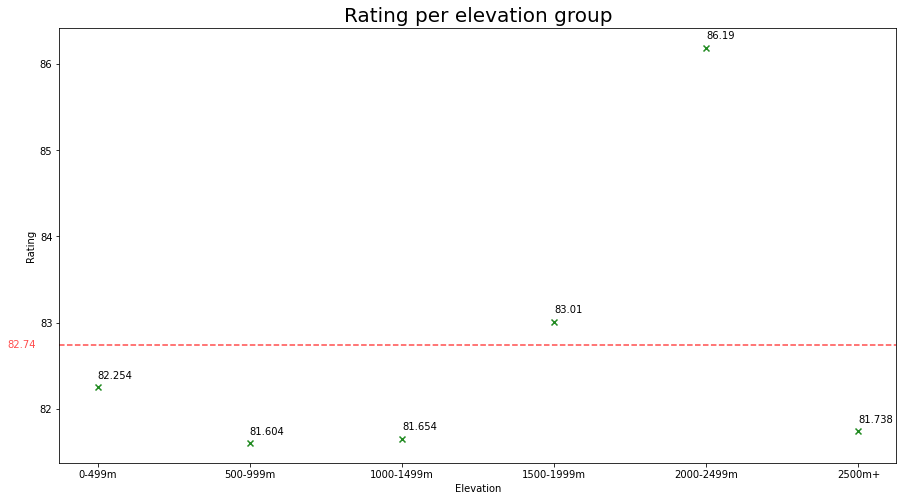

In [386]:
elevation_list = ["0-499m", "500-999m", "1000-1499m", "1500-1999m", "2000-2499m", "2500m+"]

def check_elevation(x):
    if x < 500:
       return elevation_list[0]
    elif 500 <= x < 1000:
       return elevation_list[1]
    elif 1000 <= x < 1500:
       return elevation_list[2]
    elif 1500 <= x < 2000:
       return elevation_list[3]
    elif 2000 <= x < 2500:
       return elevation_list[4]
    else:
       return elevation_list[5]

df["elevation_group"] = df["altitude_mean_meters"].apply(check_elevation)
rating_per_elevation = df.groupby(["elevation_group"])["Total_Cup_Points"].mean()
rating_per_elevation = rating_per_elevation.reindex(elevation_list)

rpe_df = pd.DataFrame(rating_per_elevation)

# scatter plot setup
fig,ax = plt.subplots(figsize=(15,8))
ax.scatter(rpe_df.index, rpe_df["Total_Cup_Points"], color="forestgreen", marker="x")

ax.set_xlabel("Elevation")
ax.set_ylabel("Rating")
ax.set_title(("Rating per elevation group"), fontsize=20)

# add horizontal line for average
mean = rpe_df["Total_Cup_Points"].mean()
ax.axhline(mean, alpha=0.7, linestyle="--", color="red")
ax.text(-0.5, mean, round(mean, 2), fontsize=10, va="center", ha="center", backgroundcolor="w", color="red", alpha=0.7)

# show values of each point
for rpe_id, rpe_rat in list(zip(rpe_df.index, rpe_df["Total_Cup_Points"])):
    ax.annotate(round(rpe_rat, 3),xy=(rpe_id, rpe_rat+0.1))


plt.show()

# Overall

To conclude (for now) this very basic data analysis and visualization project, I want to point out a few things.

Firstly, even though there is a chance that there is a correlation between the number of coffee beans rated and the ratings themselves, we need to delve deeper to be sure. 

Secondly, while I believe there is also a correlation between the elevation level and the ratings, it is not 100% clear either. The graphs definitely show us that there is a correlation, however there might be other differences that could sway the ratings. 

Finally, we got to know which countries produce the most coffee beans and the best coffee beans, also in an annual breakdown too.

All in all, we got a slight glimpse into the world of coffee beans. The data and the statistical analyses are definitely not enough to assume trends, but now we know what to look for when we are buying coffee :)